In [18]:
from rapidfuzz import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import DatasetDict, load_from_disk
import pandas as pd
import itertools
import timeit
import os
from tqdm import tqdm
import gc
import random

In [7]:
data_path = os.path.join("..","data","train_val_GO")

absolute_path = os.path.abspath(data_path)

print(absolute_path)


dataset= load_from_disk(absolute_path)

C:\Users\49176\Unistuff\PP2\prostT5-CLIP\data\train_val_GO


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['identifier', 'term', 'aspect', 'GO Name', 'GO Sentence', 'sequence', 'species', '__index_level_0__'],
        num_rows: 4299428
    })
    test: Dataset({
        features: ['identifier', 'term', 'aspect', 'GO Name', 'GO Sentence', 'sequence', 'species', '__index_level_0__'],
        num_rows: 1064435
    })
})

In [12]:


# Function to compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

# Function to compute fuzzy token sort similarity
def fuzzy_token_similarity(label1, label2):
    return fuzz.token_sort_ratio(label1, label2) / 100  # Scale to [0, 1]

# Function to compute all similarities
def compute_similarities(true_label, predicted_label):
    # Preprocessing for token-based similarity
    true_tokens = set(true_label.split())
    predicted_tokens = set(predicted_label.split())

    # Levenshtein Ratio
    levenshtein_ratio = fuzz.ratio(true_label, predicted_label) / 100  # Scale to [0, 1]

    # Jaro-Winkler Similarity
    if jaro_winkler_similarity is not None:
        jaro_winkler = jaro_winkler_similarity(true_label, predicted_label)
    else:
        jaro_winkler = None  # Jellyfish library not installed

    # Fuzzy Token Sort Ratio
    fuzzy_token_sort_ratio = fuzzy_token_similarity(true_label, predicted_label)

    # Jaccard Similarity
    jaccard_similarity_score = jaccard_similarity(true_tokens, predicted_tokens)

    # TF-IDF Cosine Similarity
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([true_label, predicted_label])
    tfidf_similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2]).flatten()[0]

    # Results
    results = {
        "Levenshtein Ratio": levenshtein_ratio,
        "Jaro-Winkler Similarity": jaro_winkler,
        "Fuzzy Token Sort Ratio": fuzzy_token_sort_ratio,
        "Jaccard Similarity": jaccard_similarity_score,
        "TF-IDF Cosine Similarity": tfidf_similarity,
    }

    return results




In [34]:
import gc
import itertools
from tqdm import tqdm
import pandas as pd

def compute_pairwise_fuzzy_similarity(dataset_dict, subsample_size=1000):
    # Extract GO Name column from train and test datasets
    train_go_names = dataset_dict['train']['GO Name']
    test_go_names = dataset_dict['test']['GO Name']

    # Subsample the train and test GO names
    train_go_names_sample = random.sample(list(train_go_names), min(subsample_size, len(train_go_names)))
    test_go_names_sample = random.sample(list(test_go_names), min(subsample_size, len(test_go_names)))

    # Free memory by deleting dataset_dict and forcing garbage collection
    del dataset_dict
    gc.collect()

    # Create unique pairs of GO Names within train and within test datasets
    train_go_name_pairs = [
        tuple(sorted(pair)) for pair in itertools.combinations(train_go_names_sample, 2)
    ]
    test_go_name_pairs = [
        tuple(sorted(pair)) for pair in itertools.combinations(test_go_names_sample, 2)
    ]

    # Remove duplicates by converting to a set and back to a list
    train_go_name_pairs = list(set(train_go_name_pairs))
    test_go_name_pairs = list(set(test_go_name_pairs))

    # Compute Fuzzy Token Similarity for each pair within train and test with progress bar
    similarity_scores = []
    for go1, go2 in tqdm(train_go_name_pairs, desc="Processing train-train pairs"):
        similarity = fuzzy_token_similarity(go1, go2)
        similarity_scores.append({"GO1": go1, "GO2": go2, "Fuzzy Token Similarity": similarity, "Test_Train": 'train-train'})

    for go1, go2 in tqdm(test_go_name_pairs, desc="Processing test-test pairs"):
        similarity = fuzzy_token_similarity(go1, go2)
        similarity_scores.append({"GO1": go1, "GO2": go2, "Fuzzy Token Similarity": similarity, "Test_Train": 'test-test'})

    # Convert to DataFrame for easy visualization
    similarity_df = pd.DataFrame(similarity_scores)
    return similarity_df


In [35]:
start_time = timeit.default_timer()
pw_similarity = compute_pairwise_fuzzy_similarity(dataset, subsample_size=5000)
execution_time = timeit.default_timer() - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Processing test-test pairs: 100%|████████████████████████████████████████| 1617933/1617933 [00:05<00:00, 288549.39it/s]


Execution time: 48.6732 seconds


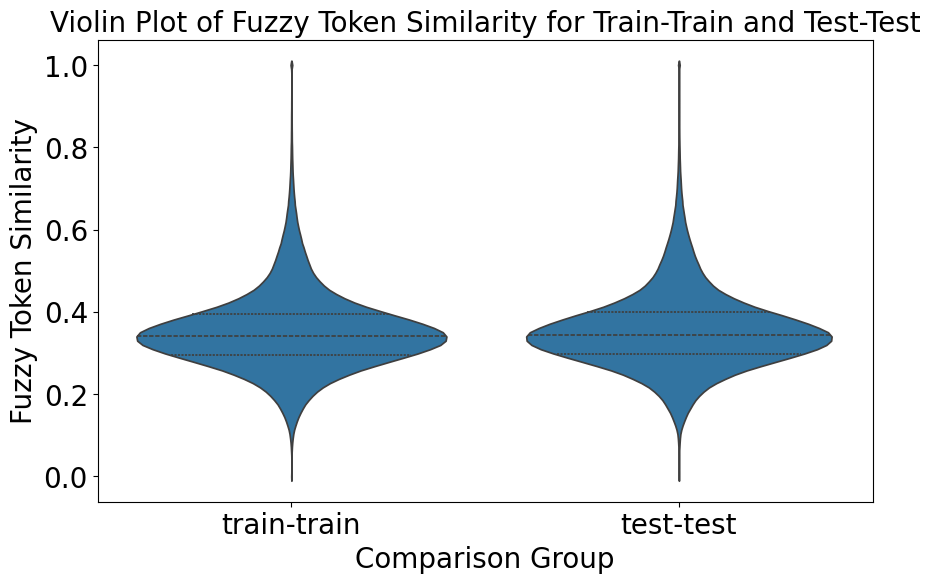

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for Fuzzy Token Similarity grouped by Test_Train
plt.figure(figsize=(10, 6))
sns.violinplot(data=pw_similarity, x="Test_Train", y="Fuzzy Token Similarity", inner="quartile")
plt.title("Violin Plot of Fuzzy Token Similarity for Train-Train and Test-Test", fontsize=20)
plt.xlabel("Comparison Group", fontsize=20)
plt.ylabel("Fuzzy Token Similarity", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [37]:
pw_similarity

,GO1,GO2,Fuzzy Token Similarity,Test_Train
0,gated channel activity,release of sequestered calcium ion into cytosol,0.376812,train-train
1,cellular nitrogen compound metabolic process,regulation of leukocyte apoptotic process,0.423529,train-train
2,myeloid cell homeostasis,regulation of localization,0.320000,train-train
3,cellular response to osmotic stress,regulation of myeloid cell differentiation,0.415584,train-train
4,sulfate adenylyltransferase activity,ubiquitin protein ligase activity,0.521739,train-train
...,...,...,...,...
3187692,presynaptic membrane,regulation of cell differentiation,0.370370,test-test
3187693,cytosolic ribosome,regulation of muscle system process,0.377358,test-test
3187694,nuclear protein-containing complex,positive regulation of insulin secretion,0.378378,test-test
3187695,regulation of anion channel activity by blue l...,response to carbohydrate,0.297297,test-test


In [47]:
# Filter out rows where Fuzzy Token Similarity equals 1
filtered_pw_similarity = pw_similarity[pw_similarity["Fuzzy Token Similarity"] == 1]

# Sort the filtered DataFrame by Fuzzy Token Similarity in descending order
top_filtered_pw_similarity = filtered_pw_similarity.sort_values("Fuzzy Token Similarity", ascending=False).head(50)



In [48]:
top_filtered_pw_similarity

,GO1,GO2,Fuzzy Token Similarity,Test_Train
2909,small molecule metabolic process,small molecule metabolic process,1.0,train-train
2105748,circulatory system development,circulatory system development,1.0,test-test
2024485,regulation of defense response,regulation of defense response,1.0,test-test
2023423,mitochondrial respirasome,mitochondrial respirasome,1.0,test-test
2019752,organophosphate metabolic process,organophosphate metabolic process,1.0,test-test
2019254,positive regulation of phosphorylation,positive regulation of phosphorylation,1.0,test-test
2017489,vacuole,vacuole,1.0,test-test
2016573,protein kinase activator activity,protein kinase activator activity,1.0,test-test
2014365,organic cyclic compound metabolic process,organic cyclic compound metabolic process,1.0,test-test
2012956,cellular macromolecule localization,cellular macromolecule localization,1.0,test-test


In [44]:
print(top_filtered_pw_similarity.head(1).GO2)

1431879    RNA polymerase III cis-regulatory region seque...
Name: GO2, dtype: object
